### ML 데이터 준비

- data__데이터전처리통합.ipynb 아래 코드에서 담당 카테고리의 변경사항 있을시 수정해서 사용

In [22]:
# 라이브러리
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path

# 환경설정
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)      # 행 전체 표시
pd.set_option('display.max_columns', None)  # 열 전체 표시
pd.set_option('display.width', None)        # 가로폭 자동 맞춤
pd.set_option('display.max_colwidth', None) # 셀 안의 텍스트 생략 방지
pd.set_option('display.float_format', '{:.6f}'.format)

# 경로 설정
ROOT_DIR = Path("").resolve().parent.parent

# 데이터 경로
DATA_DIR = ROOT_DIR / "data"
DATA_PATH = DATA_DIR / "analy_data.csv"
SAVE_FILE = "preprocessed_v1.csv"

# JSON 컬럼 관리 파일 로드
with open('../team/columns.json', "r", encoding="utf-8") as f:
    columns_dict = json.load(f)

# 공통 함수 
def get_columns(*categories):
    """columns.json의 카테고리별 use=y 컬럼 추출"""
    selected = []
    for cat in categories:
        for col, meta in columns_dict[cat].items():
            if meta.get("use", "n") == "y": 
                selected.append(col)
    
    if "churn" not in selected:
        selected.append("churn")

    if "exmprs_no" not in selected:
        selected.append("exmprs_no")

    return selected

def rename_to_kor(df):
    """columns.json의 name으로 한글 컬럼명 매핑"""
    rename_map = {
        col: meta["name"]
        for cat in columns_dict.values()
        for col, meta in cat.items()
        if col in df.columns
    }
    return df.rename(columns=rename_map)

# 1. 기본정보 + 가구조사 
def preprocess_basic_house(data_path):
    cols = get_columns("기본정보", "가구조사")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    if "CTPRVN_CODE" in df.columns:
        df['CTPRVN_CODE'] = df['CTPRVN_CODE'].apply(lambda x: x.split("'")[1])
    
    if "SPOT_NO" in df.columns:
        df['SPOT_NO'] = df['SPOT_NO'].apply(lambda x: x.split("'")[1])
    
    if "sex" in df.columns:
        df['sex'] = df['sex'].apply(lambda x: 1 if x == 1 else 2).astype(str)

    # NaN 변경
    for col in ["fma_04z1", "nue_01z1", "fma_27z1", "fma_26z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["fma_13z1", "fma_14z1"]:
        if col in df.columns:
            df.loc[df[col] >= 77777, col] = np.nan

    for col in ["fma_24z2"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 2. 식생활 + 비만및체중조절 + 구강건강
def preprocess_diet_obesity_oral(data_path):
    cols = get_columns("식생활", "비만및체중조절", "구강건강")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경
    for col in ["nua_01z2", "nuc_02z1", "nuc_03z1", "obb_02a1", "obb_02b1", "obb_02d1", "ora_01z1", "orb_01z1", "ord_01d2", "ord_05z1", "ord_01f3"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["ore_03z2"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 3. 음주 + 신체활동
def preprocess_drink_physical(data_path):
    cols = get_columns("음주", "신체활동")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # 값 변경
    if "drb_01z3" in df.columns:
        df["drb_01z3"] = df["drb_01z3"].replace(8, 1)

    if "drb_03z1" in df.columns:
        df["drb_03z1"] = df["drb_03z1"].replace(8, -1)

    # NaN 변경 
    for col in ["drb_01z3", "drb_03z1", "drg_01z3", "pha_11z1", "drb_04z1", "drb_05z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["pha_04z1", "pha_07z1", "phb_01z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 4. 정신건강 + 보건이용
def preprocess_mental_health(data_path):
    cols = get_columns("정신건강", "보건이용")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경 
    for col in ["mta_01z1", "mta_02z1", "mtc_08z1", "mtc_12c1", "mtc_12h1", "mtj_05z2", "mtj_10z1", "mtj_11z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["edit_mtc_03z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 5. 건강행태 + 교육및경제활동
def preprocess_behavior_education(data_path):
    cols = get_columns("건강행태", "교육및경제활동")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경
    for col in ["smf_01z1", "sma_01z1", "sma_03z2", "smb_09z1", "sma_36z1", "sma_37z1", "sma_08z1", "sma_12z2"\
                "smd_02z3", "smd_01z3", "smc_08z2", "smc_09z2", "smc_10z2", "sob_02z1", "soa_01z1", "soa_07z1", "sod_02z3"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["smb_02z1", "smb_05z1", "sma_11z2", "sob_01z1", "soa_06z2", "smb_12z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    for col in ["smb_13z1", "smb_03z1", "smb_04z1", "smb_06z1", "smb_11z1"]:
            if col in df.columns:
                df.loc[df[col] >= 777, col] = np.nan
    return df

df_basic = preprocess_basic_house(DATA_PATH)
df_health = preprocess_diet_obesity_oral(DATA_PATH)
df_drink = preprocess_drink_physical(DATA_PATH)
df_mental = preprocess_mental_health(DATA_PATH)
df_behavior = preprocess_behavior_education(DATA_PATH)

dfs = [df_basic, df_health, df_drink, df_mental, df_behavior]
df_merge = dfs[0]
for temp in dfs[1:]:
    join_cols = [c for c in ["exmprs_no", "churn"] if c in df_merge.columns and c in temp.columns]
    if join_cols:
        df_merge = pd.merge(df_merge, temp, on=join_cols, how="outer")

print("컬럼 식별 완료된 데이터 크기:", df_merge.shape,'-2')
print(f"결측치 비율: (평균) {df_merge.isna().mean().mean() * 100:.2f}%")

#=========================
# 추가 전처리
#=========================
# doyeon
#=========================
# '월간 폭음 경험(남)', '월간 폭음 경험(여)' ['drb_04z1', 'drb_05z1'] -> '월간 폭음 경험' ['drb_binge_monthly'] 통합
df_merge['sex'] = df_merge['sex']
df_merge['drb_binge_monthly'] = np.where(df_merge['sex'] == 1, df_merge['drb_04z1'], df_merge['drb_05z1'])
df_merge.drop(['drb_04z1', 'drb_05z1'], axis=1, inplace=True)

# 값변경
df_merge['drb_binge_monthly'] = df_merge['drb_binge_monthly'].replace(8, -1)
df_merge.loc[df_merge['drb_binge_monthly'] >= 7, 'drb_binge_monthly'] = np.nan

# 범주형 칼럼 object형 변환
df_merge['dra_01z1'] = df_merge['dra_01z1'].astype('object')

#=========================
# soso
#=========================
# 연령대
df_merge['age_group'] = (df_merge['age'] // 10) * 10

# 1인가구
df_merge['is_single'] = np.where((df_merge['mbhld_co'] <= 1), 1, 0)

# 월간소득 기준 가구소득컬럼 통합
df_merge['fma_14z1_add'] = df_merge['fma_14z1'] 
df_merge['fma_14z1_add'] = round(df_merge['fma_14z1_add'].fillna(df_merge['fma_13z1'] / 12))
df_merge['fma_14z1_log'] = np.log1p(df_merge['fma_14z1_add'])

bins = [0, 50, 100, 200, 300, 400, 500, 600, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]
df_merge['fma_14z1_group'] = pd.cut(df_merge['fma_14z1_add'], bins=bins, labels=labels, right=False)
df_merge['fma_14z1_group'] = np.where(df_merge['fma_14z1_group'].isna(), df_merge['fma_24z2'].astype(float), df_merge['fma_14z1_group'])

# 치매가족여부
def get_dementia_case(row):
    if row['fma_27z1'] == 1 and row['fma_26z1'] == 1:
        return 1 # 치매가족 있음 + 같이 거주
    elif row['fma_27z1'] == 1 and row['fma_26z1'] == 2:
        return 2 # 치매가족 있음 + 비거주
    elif row['fma_27z1'] == 2:
        return 3 # 치매가족 없음
    else:
        return np.nan

df_merge['fma_dementia_case'] = df_merge.apply(get_dementia_case, axis=1)
df_merge.drop(['fma_13z1', 'fma_14z1','fma_27z1','fma_26z1'], axis=1, inplace=True)
print("추가 전처리 후 데이터 크기:", df_merge.shape ,'-2')
print("exmprs_no, wt_p 필요시 활용하기 위해 포함해놓음, 제외하고 사용")

컬럼 식별 완료된 데이터 크기: (89822, 73) -2
결측치 비율: (평균) 27.45%
추가 전처리 후 데이터 크기: (89822, 74) -2
exmprs_no, wt_p 필요시 활용하기 위해 포함해놓음, 제외하고 사용


In [48]:
# 한글컬럼으로 확인할 시 사용
df_merge_kor = rename_to_kor(df_merge)

---

### 모델에 들어가는 피처 핸들링하고 테스트 해보기 (포맷 고정)

In [59]:
# 위 코드 실행 결과: df_merge
df = df_merge.copy()
df = df.drop(['exmprs_no','wt_p'], axis=1)
df.head()

,age,sex,CTPRVN_CODE,SPOT_NO,mbhld_co,reside_adult_co,fma_04z1,fma_24z2,nue_01z1,churn,nua_01z2,nuc_02z1,nuc_03z1,obb_02a1,obb_02b1,obb_02d1,ora_01z1,orb_01z1,ord_01d2,ord_05z1,ord_01f3,ore_03z2,dra_01z1,drb_01z3,drb_03z1,drg_01z3,pha_04z1,pha_07z1,phb_01z1,pha_11z1,mta_01z1,mta_02z1,edit_mtc_03z1,mtc_08z1,mtc_12c1,mtc_12h1,mtj_05z2,mtj_10z1,mtj_11z1,smf_01z1,sma_01z1,smb_01z1,smb_02z1,smb_03z1,smb_04z1,smb_05z1,smb_06z1,smb_09z1,sma_36z1,smb_11z1,smb_12z1,smb_13z1,sma_08z1,sma_11z2,smd_02z3,smd_01z3,smc_08z2,smc_09z2,smc_10z2,sob_01z1,sob_02z1,soa_01z1,soa_06z2,soa_07z1,sod_02z3,drb_binge_monthly,age_group,is_single,fma_14z1_add,fma_14z1_log,fma_14z1_group,fma_dementia_case
0,31.000000,1,11,00102,1.000000,1.000000,3.000000,NaN,1.000000,1,4.000000,2.000000,NaN,1.000000,2.000000,2.000000,3.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,5.000000,3.000000,1.000000,2.000000,2.000000,5.000000,3.000000,2.000000,2.000000,0.000000,NaN,4.000000,2.000000,NaN,NaN,NaN,1.000000,1.000000,888.000000,NaN,NaN,2.000000,0.000000,1.000000,3.000000,2.000000,NaN,NaN,NaN,2.000000,NaN,8.000000,NaN,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,3.000000,2.000000,5.000000,NaN,30.000000,1,1000.000000,6.908755,8.000000,3.000000
1,37.000000,1,11,00102,3.000000,2.000000,3.000000,NaN,1.000000,0,2.000000,1.000000,1.000000,NaN,NaN,NaN,2.000000,5.000000,2.000000,1.000000,1.000000,NaN,1.000000,4.000000,4.000000,1.000000,3.000000,1.000000,7.000000,1.000000,4.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,4.000000,2.000000,NaN,2.000000,5.000000,1.000000,1.000000,4.000000,2.000000,1.000000,NaN,30.000000,0,300.000000,5.707110,5.000000,3.000000
2,36.000000,2,11,00102,3.000000,2.000000,3.000000,NaN,1.000000,1,4.000000,2.000000,NaN,2.000000,2.000000,2.000000,2.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,5.000000,4.000000,2.000000,0.000000,4.000000,7.000000,1.000000,2.000000,2.000000,1.000000,NaN,3.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,888.000000,NaN,NaN,5.000000,0.000000,10.000000,3.000000,2.000000,NaN,NaN,NaN,2.000000,NaN,8.000000,NaN,2.000000,NaN,2.000000,6.000000,1.000000,1.000000,4.000000,2.000000,1.000000,4.000000,30.000000,0,300.000000,5.707110,5.000000,3.000000
3,36.000000,1,11,00102,2.000000,2.000000,3.000000,NaN,1.000000,0,4.000000,1.000000,NaN,1.000000,2.000000,2.000000,4.000000,3.000000,2.000000,1.000000,1.000000,NaN,1.000000,4.000000,4.000000,1.000000,0.000000,3.000000,5.000000,1.000000,2.000000,2.000000,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,2.000000,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,3.000000,2.000000,1.000000,NaN,30.000000,0,667.000000,6.504288,8.000000,3.000000
4,64.000000,1,11,00191,1.000000,1.000000,1.000000,NaN,4.000000,0,2.000000,2.000000,NaN,NaN,NaN,NaN,2.000000,1.000000,1.000000,NaN,1.000000,3.000000,1.000000,4.000000,5.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,22.000000,6.000000,4.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,4.000000,2.000000,NaN,3.000000,3.000000,3.000000,2.000000,NaN,NaN,5.000000,NaN,60.000000,1,50.000000,3.931826,2.000000,3.000000


In [56]:
# Train/Test 분할 만들기
from sklearn.model_selection import train_test_split


df = df_merge.copy()
df = df.drop(['exmprs_no','wt_p'], axis=1)

y = df['churn'].astype(int)
X = df.drop(columns=['churn'])

# 층화 분할로 8:2 쪼개기 (클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=2,
    stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (71857, 71)  Test: (17965, 71)


Train Accuracy: 1.0000
Test  Accuracy: 0.9978

Confusion Matrix (counts)
 [[8084   30]
 [   9 9842]]

Classification Report @0.5
               precision    recall  f1-score   support

           0     0.9989    0.9963    0.9976      8114
           1     0.9970    0.9991    0.9980      9851

    accuracy                         0.9978     17965
   macro avg     0.9979    0.9977    0.9978     17965
weighted avg     0.9978    0.9978    0.9978     17965

Test PR-AUC : 1.0000
Test ROC-AUC: 1.0000


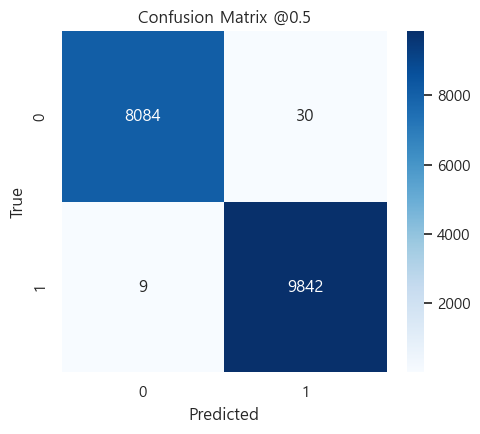

In [ ]:
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,average_precision_score, roc_auc_score
)
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 전처리: 수치 = median impute, 범주 = most_frequent + OHE
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_include=['object','category'])

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        # ("scaler", StandardScaler())  # ← 제거
    ]), num_sel),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_sel)
])

# 모델
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.07,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    eval_metric="aucpr",
    random_state=2,
    n_jobs=-1
)

pipe = Pipeline([
    ("pre", preprocess),
    ("model", model)
])

# 학습 
pipe.fit(X_train, y_train)

# 예측 
y_pred_train = pipe.predict(X_train)              # 임계값 0.5 분류 라벨
y_pred_test  = pipe.predict(X_test)

# 정확도
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test  Accuracy: {accuracy_score(y_test,  y_pred_test):.4f}")

# 오차행렬/리포트
cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix (counts)\n", cm)  
print("\nClassification Report @0.5\n", classification_report(y_test, y_pred_test, digits=4))

# 확률 기반 지표(PR-AUC, ROC-AUC)
y_prob_test = pipe.predict_proba(X_test)[:, 1]
print("Test PR-AUC :", f"{average_precision_score(y_test, y_prob_test):.4f}")
print("Test ROC-AUC:", f"{roc_auc_score(y_test, y_prob_test):.4f}")

# 오차행렬 시각화
plt.figure(figsize=(5,4.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix @0.5")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

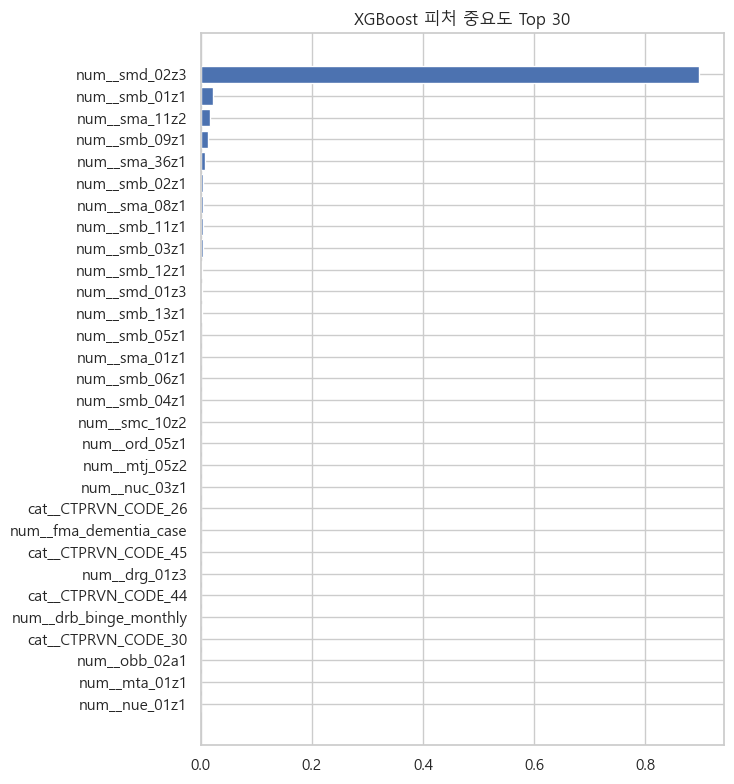

In [58]:
pipe.fit(X, y)
feat_names = pipe.named_steps["pre"].get_feature_names_out()
importances = pipe.named_steps["model"].feature_importances_

order = np.argsort(importances)[::-1][:30]
plt.figure(figsize=(7.5,8))
plt.barh(range(len(order)), importances[order][::-1])
plt.yticks(range(len(order)), np.array(feat_names)[order][::-1])
plt.title("XGBoost 피처 중요도 Top 30")
plt.tight_layout(); plt.show()

In [28]:
# 결측치 처리

In [29]:
# 파생 변수 생성

In [30]:
# 인코딩 

In [31]:
# 최종 피처 선택 (예시)
fnl_col = ['age', 'sex', 'CTPRVN_CODE', 'SPOT_NO', 'mbhld_co', 'reside_adult_co',
       'fma_04z1', 'fma_24z2', 'nue_01z1', 'churn', 'nua_01z2', 'nuc_02z1',
       'nuc_03z1', 'obb_02a1', 'obb_02b1', 'obb_02d1', 'ora_01z1', 'orb_01z1',
       'ord_01d2', 'ord_05z1', 'ord_01f3', 'ore_03z2', 'dra_01z1', 'drb_01z3',
       'drb_03z1', 'drg_01z3', 'pha_04z1', 'pha_07z1', 'phb_01z1', 'pha_11z1',
       'mta_01z1', 'mta_02z1', 'edit_mtc_03z1', 'mtc_08z1', 'mtc_12c1',
       'mtc_12h1', 'mtj_05z2', 'mtj_10z1', 'mtj_11z1', 'smf_01z1',
       'smb_01z1', 'smb_02z1', 'smb_03z1', 'smb_04z1', 'smb_05z1',
       'smb_06z1', 'sma_36z1', 'smb_12z1',
       'sma_08z1', 'sma_11z2',
       'smc_08z2', 'smc_09z2', 'smc_10z2', 'sob_01z1', 'sob_02z1', 'soa_01z1',
       'soa_06z2', 'soa_07z1', 'sod_02z3', 'drb_binge_monthly', 'age_group',
       'is_single', 'fma_14z1_add', 'fma_14z1_log', 'fma_14z1_group',
       'fma_dementia_case']

# ['sma_03z2', 'sma_37z1', 'sma_12z2'] -> 타겟변수 만든 변수
# ['smd_02z3','smd_01z3', 'smb_09z1', 'smb_11z1', 'smb_13z1', 'sma_01z1', ...] 제외 -> 예측하고자 하는 타겟의 정보를 가지고있는 변수
df = df[fnl_col]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89822 entries, 0 to 89821
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                89822 non-null  float64
 1   sex                89822 non-null  object 
 2   CTPRVN_CODE        89822 non-null  object 
 3   SPOT_NO            89822 non-null  object 
 4   mbhld_co           89822 non-null  float64
 5   reside_adult_co    89822 non-null  float64
 6   fma_04z1           89801 non-null  float64
 7   fma_24z2           1095 non-null   float64
 8   nue_01z1           89800 non-null  float64
 9   churn              89822 non-null  int64  
 10  nua_01z2           89822 non-null  float64
 11  nuc_02z1           89315 non-null  float64
 12  nuc_03z1           19738 non-null  float64
 13  obb_02a1           44065 non-null  float64
 14  obb_02b1           44058 non-null  float64
 15  obb_02d1           44058 non-null  float64
 16  ora_01z1           898

(71857, 65) (71857,) (17965, 65) (17965,) 

Accuracy: 0.9702198719732814
smb_06z1            0.873343
sma_36z1            0.053993
sma_11z2            0.006367
SPOT_NO             0.004656
age                 0.004530
smb_04z1            0.003638
soa_06z2            0.003103
CTPRVN_CODE         0.002968
smb_12z1            0.002792
pha_07z1            0.001884
drb_03z1            0.001804
edit_mtc_03z1       0.001711
mtc_12c1            0.001672
drb_01z3            0.001656
pha_11z1            0.001606
phb_01z1            0.001560
ord_05z1            0.001559
fma_14z1_add        0.001555
smb_03z1            0.001548
reside_adult_co     0.001503
mbhld_co            0.001436
fma_14z1_log        0.001434
sob_01z1            0.001369
orb_01z1            0.001339
pha_04z1            0.001248
drg_01z3            0.001232
ora_01z1            0.001159
smb_05z1            0.001091
nua_01z2            0.001074
mtc_08z1            0.000957
sod_02z3            0.000880
ord_01d2            0.000878

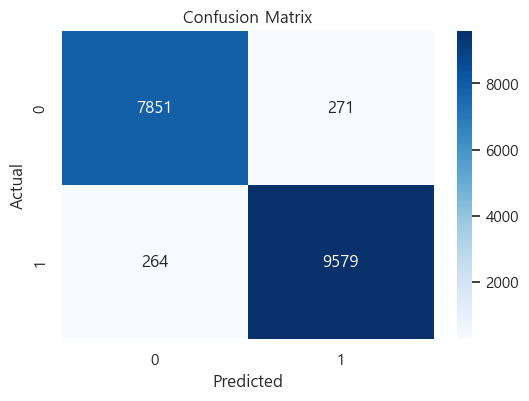

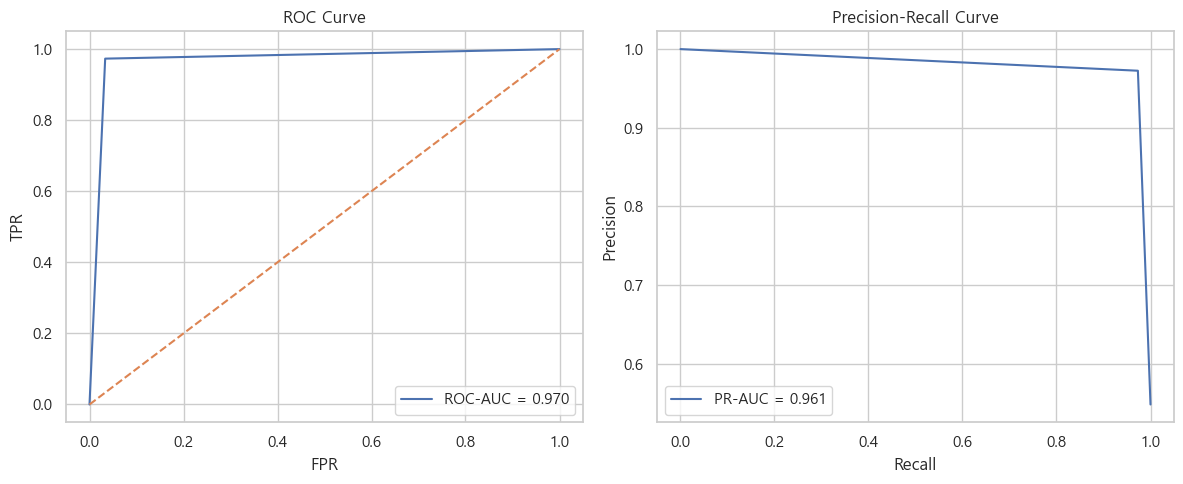

In [33]:
# 모델
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 분리
X = df.drop('churn', axis=1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, '\n')

# 모델 학습
model = DecisionTreeClassifier(random_state=2)
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# 변수중요도
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
print(feature_importance.sort_values(ascending=False), '\n')

# 혼동행렬
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
y_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# PR-AUC
pr_auc = average_precision_score(y_test, y_prob)
prec, recall, _ = precision_recall_curve(y_test, y_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
axes[0].plot([0,1],[0,1],'--')
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC Curve")
axes[0].legend()

axes[1].plot(recall, prec, label=f"PR-AUC = {pr_auc:.3f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend()

plt.tight_layout()
plt.show()